In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns


def idxwhere(x):
    return x[x].index

In [2]:
color_map = {'acarbose': 'goldenrod', 'control': 'darkblue',
             'UM': 'darkblue', 'UT': 'darkgreen',
             'male': 'blue', 'female': 'magenta',
             'C2013': 'blue', 'Glenn': 'red',
             'B1A': 'lightblue', 'B1B': 'lightgreen',
             'untrusted': 'grey',
             0: 'white', 1: 'black'}

In [3]:
con = sqlite3.connect('data/core.muri2.2.denorm.db')

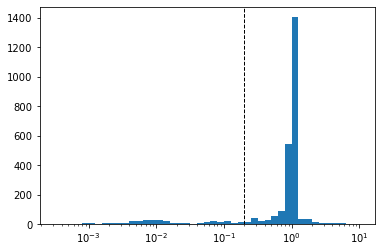

In [4]:
cvrg_ratio_B1A = pd.read_sql(
    """
    SELECT feature_id, coverage_ratio
    FROM variant_cross_coverage
    WHERE genome_id = 'B1A'
    """,
    index_col=['feature_id'],
    con=con).squeeze()

_min = -3.5
_max = 1
bins = np.logspace(_min, _max, num=int((_max - _min) * 10 + 1))
plt.hist(cvrg_ratio_B1A + bins[0], bins=bins)
plt.axvline(1/5, lw=1, linestyle='--', color='k')

plt.xscale('log')
#plt.yscale('symlog')

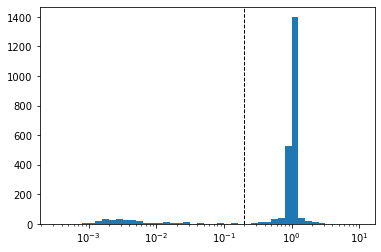

In [5]:
cvrg_ratio_B1B = pd.read_sql(
    """
    SELECT feature_id, coverage_ratio
    FROM variant_cross_coverage
    WHERE genome_id = 'B1B'
    """,
    index_col=['feature_id'],
    con=con).squeeze()

_min = -3.5
_max = 1
bins = np.logspace(_min, _max, num=int((_max - _min) * 10 + 1))
plt.hist(cvrg_ratio_B1B + bins[0], bins=bins)
plt.axvline(1/5, lw=1, linestyle='--', color='k')
plt.xscale('log')
#plt.yscale('symlog')

In [6]:
feature = pd.read_sql(
    """
    SELECT feature_id, sequence_id, genome_id
    FROM feature
    JOIN sequence USING (sequence_id)
    WHERE genome_id IN ('B1A', 'B1B')
    """,
    index_col=['feature_id'],
    con=con
)
feature['sequence_alternating'] = (
    feature.sequence_id.map(
        pd.DataFrame({'sequence_id': feature.sequence_id.unique()})
        .reset_index().set_index('sequence_id')
        .squeeze().apply(lambda x: x % 2)
    )
)

In [7]:
cvrg_B1A = (
    pd.read_sql(
        """
        SELECT feature_id, library_id, coverage
        FROM feature_library_coverage
        JOIN feature USING (feature_id)
        JOIN sequence USING (sequence_id)
        WHERE genome_id = 'B1A'
        """,
    index_col=['feature_id', 'library_id'],
    con=con)
            .squeeze()
            .unstack(fill_value=0)
           )

cvrg_B1B = (
    pd.read_sql(
        """
        SELECT feature_id, library_id, coverage
        FROM feature_library_coverage
        JOIN feature USING (feature_id)
        JOIN sequence USING (sequence_id)
        WHERE genome_id = 'B1B'
        """,
    index_col=['feature_id', 'library_id'],
    con=con)
            .squeeze()
            .unstack(fill_value=0)
           )



with open('data/core.a.mags/B1A.g.library.list') as f:
    library_list_B1A = list(set([line.strip() for line in f]) & set(cvrg_B1A.columns))
    
with open('data/core.a.mags/B1B.g.library.list') as f:
    library_list_B1B = list(set([line.strip() for line in f]) & set(cvrg_B1B.columns))
    
assert not set(library_list_B1A) & set(library_list_B1B)

In [8]:
library = pd.read_sql(
    """
    SELECT *
    FROM library
    JOIN extraction USING (extraction_id)
    JOIN sample USING (sample_id)
    JOIN mouse USING (mouse_id)
    """,
    index_col='library_id',
    con=con
)
library.loc['variant'] = 'untrusted'
library.loc[library_list_B1A, 'variant'] = 'B1A'
library.loc[library_list_B1B, 'variant'] = 'B1B'

In [9]:
# Styles

gene_content_heatmap_kwargs = dict(cmap='copper', norm=mpl.colors.SymLogNorm(1e-1, vmin=0, vmax=10, base=10))

/Users/byronsmith/anaconda3/envs/compbio/lib/python3.8/site-packages/seaborn/matrix.py:301: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mesh = ax.pcolormesh(self.plot_data, vmin=self.vmin, vmax=self.vmax,


<AxesSubplot:xlabel='feature_id', ylabel='library_id'>

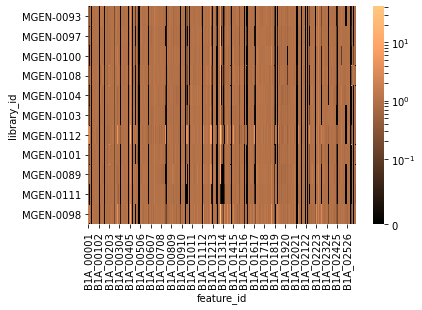

In [10]:
_library_list = list(set(library_list_B1B) & set(cvrg_B1A.columns))

cvrg_B1A_features_in_B1B_libs = cvrg_B1A[_library_list]
median_cvrg_B1A_in_B1B_libs = cvrg_B1A_features_in_B1B_libs.median()
ratio_cvrg_B1A_in_B1B_libs = cvrg_B1A_features_in_B1B_libs / median_cvrg_B1A_in_B1B_libs

sns.heatmap(ratio_cvrg_B1A_in_B1B_libs.T, **gene_content_heatmap_kwargs)

<AxesSubplot:xlabel='feature_id', ylabel='library_id'>

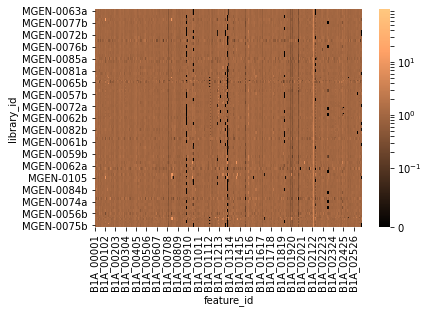

In [11]:
_library_list = list(set(library_list_B1A) & set(cvrg_B1A.columns))

cvrg_B1A_features_in_B1A_libs = cvrg_B1A[_library_list]
median_cvrg_B1A_in_B1A_libs = cvrg_B1A_features_in_B1A_libs.median()
ratio_cvrg_B1A_in_B1A_libs = cvrg_B1A_features_in_B1A_libs / median_cvrg_B1A_in_B1A_libs

sns.heatmap(ratio_cvrg_B1A_in_B1A_libs.T, **gene_content_heatmap_kwargs)

<AxesSubplot:xlabel='feature_id', ylabel='library_id'>

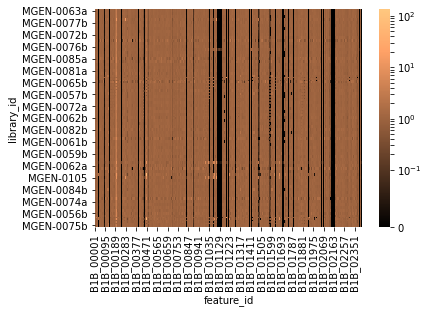

In [12]:
_library_list = list(set(library_list_B1A) & set(cvrg_B1B.columns))

cvrg_B1B_features_in_B1A_libs = cvrg_B1B[_library_list]
median_cvrg_B1B_in_B1A_libs = cvrg_B1B_features_in_B1A_libs.median()
ratio_cvrg_B1B_in_B1A_libs = cvrg_B1B_features_in_B1A_libs / median_cvrg_B1B_in_B1A_libs

sns.heatmap(ratio_cvrg_B1B_in_B1A_libs.T, **gene_content_heatmap_kwargs)

<AxesSubplot:xlabel='feature_id', ylabel='library_id'>

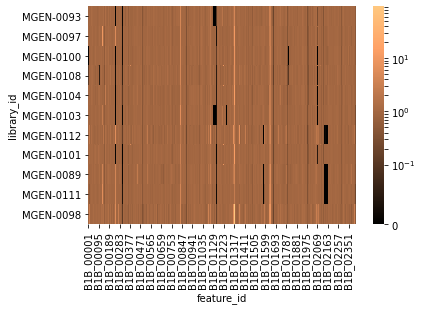

In [13]:
_library_list = list(set(library_list_B1B) & set(cvrg_B1B.columns))

cvrg_B1B_features_in_B1B_libs = cvrg_B1B[_library_list]
median_cvrg_B1B_in_B1B_libs = cvrg_B1B_features_in_B1B_libs.median()
ratio_cvrg_B1B_in_B1B_libs = cvrg_B1B_features_in_B1B_libs / median_cvrg_B1B_in_B1B_libs

sns.heatmap(ratio_cvrg_B1B_in_B1B_libs.T, **gene_content_heatmap_kwargs)

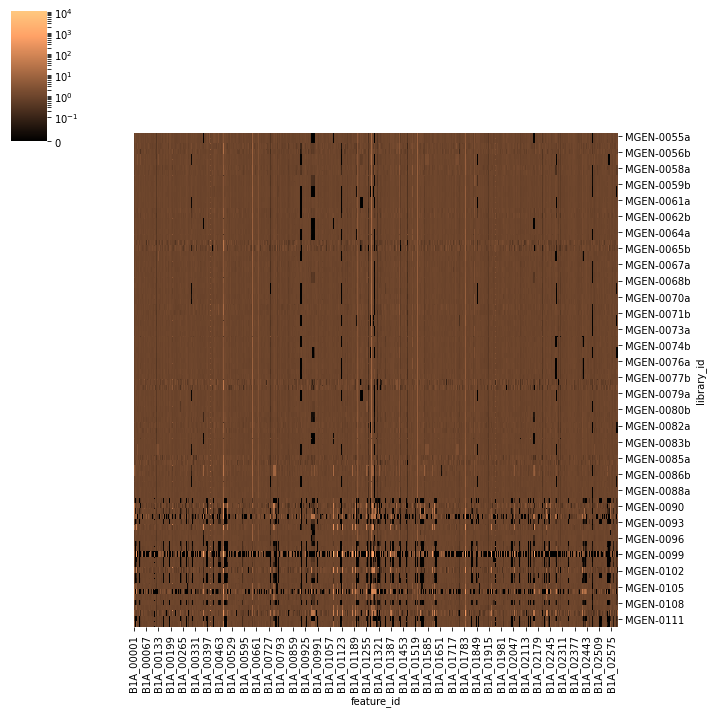

In [14]:
cvrg_B1A_features = cvrg_B1A
median_cvrg_B1A = cvrg_B1A_features.median()
ratio_cvrg_B1A = cvrg_B1A_features / median_cvrg_B1A

sns.clustermap(ratio_cvrg_B1A.T, row_cluster=False, col_cluster=False, **gene_content_heatmap_kwargs)

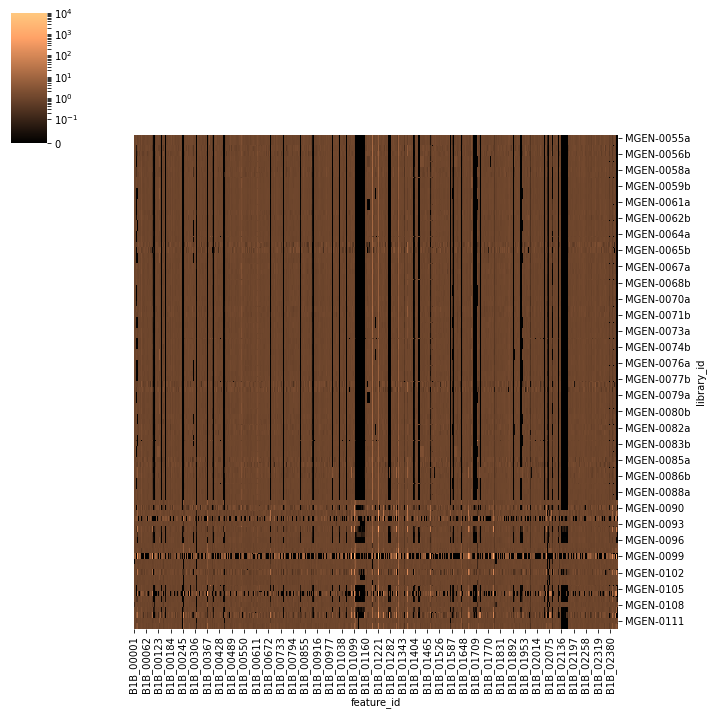

In [15]:
cvrg_B1B_features = cvrg_B1B
median_cvrg_B1B = cvrg_B1B_features.median()
ratio_cvrg_B1B = cvrg_B1B_features / median_cvrg_B1B

sns.clustermap(ratio_cvrg_B1B.T, row_cluster=False, col_cluster=False, **gene_content_heatmap_kwargs)

/Users/byronsmith/anaconda3/envs/compbio/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


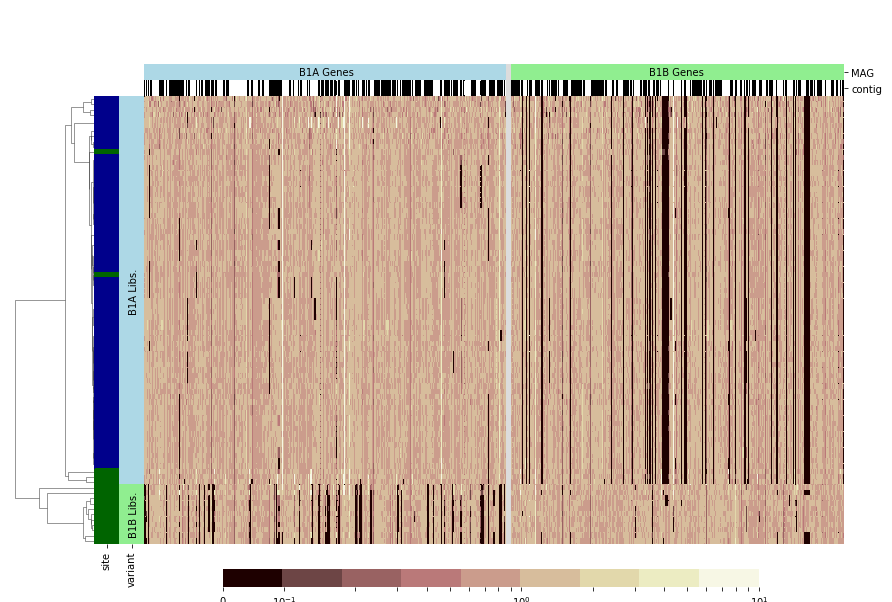

In [16]:
dmat_raw = [[ratio_cvrg_B1A_in_B1A_libs, ratio_cvrg_B1B_in_B1A_libs],
        [ratio_cvrg_B1A_in_B1B_libs, ratio_cvrg_B1B_in_B1B_libs]]
xsplit, ysplit = dmat_raw[0][0].shape
dmat = pd.concat([pd.concat([d for d in d1], axis='index') for d1 in dmat_raw], axis='columns')

# Discretize a continuous colormap.
ncolors = 9
cmap = plt.cm.pink  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in np.linspace(0, 0.9, num=ncolors)]
# force the first color entry to be grey

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, ncolors)

#fig, axs = plt.subplots(2, 2, figsize=(10, 10))
cg = sns.clustermap(
    dmat.T, xticklabels=0, yticklabels=0,
    row_colors=pd.DataFrame([library.site.map(color_map), library.variant.map(color_map)]).T,
    col_colors=pd.DataFrame({'MAG': feature.genome_id.map(color_map), 'contig': feature.sequence_alternating.map(color_map)}),
    row_cluster=True, col_cluster=False, metric='cosine',
    cmap=cmap, vmax=1e1, norm=mpl.colors.SymLogNorm(1e-1, linscale=0.23, vmin=0, vmax=1e1, base=10),
    rasterized=True, linewidths=0.,
    cbar_kws=dict(orientation='horizontal', label='relative coverage'),
    cbar_pos=(0.25, 0.02, 0.6, 0.03),
    dendrogram_ratio=0.1,
    figsize=(12.5, 8),
)
ax = cg.ax_heatmap
ax.axvline(xsplit, color='gainsboro', lw=5)
cg.ax_col_colors.axvline(xsplit, color='gainsboro', lw=5)
# ax.axhline(ysplit, color='w')
ax.set_xlabel('')
ax.set_ylabel('')
#ax.set_yticklabels([])

col_colors_y_offset = 0.5
cg.ax_col_colors.annotate(
    'B1A Genes',
    xy=(dmat_raw[0][0].shape[0] / 2, col_colors_y_offset),
    va='center', ha='center'
)
cg.ax_col_colors.annotate(
    'B1B Genes',
    xy=(dmat_raw[0][0].shape[0] + dmat_raw[0][1].shape[0] / 2, col_colors_y_offset),
    va='center', ha='center'
)

row_colors_x_offset = 1.6
cg.ax_row_colors.annotate(
    'B1A Libs.',
    xy=(row_colors_x_offset, dmat_raw[0][0].shape[1] / 2),
    va='center', ha='center', rotation=90,
)
cg.ax_row_colors.annotate(
    'B1B Libs.',
    xy=(row_colors_x_offset, dmat_raw[0][1].shape[1] + dmat_raw[1][1].shape[1] / 2),
    va='center', ha='center', rotation=90,
)

plt.savefig('fig/B1_strain_comparison_heatmap_no_ambig.pdf', dpi=250, bbox_inches='tight')

/Users/byronsmith/anaconda3/envs/compbio/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/byronsmith/anaconda3/envs/compbio/lib/python3.8/site-packages/seaborn/matrix.py:301: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mesh = ax.pcolormesh(self.plot_data, vmin=self.vmin, vmax=self.vmax,


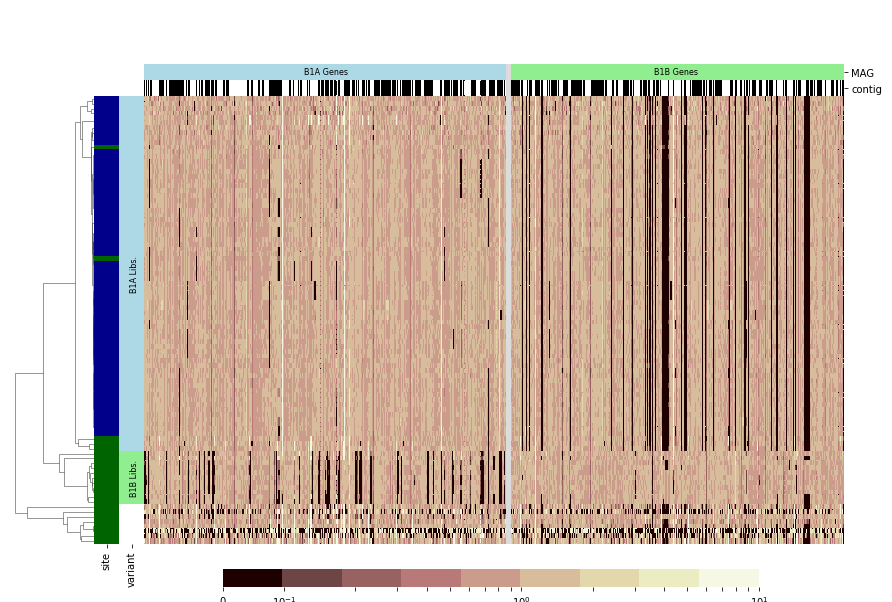

In [17]:
dmat_raw = [[ratio_cvrg_B1A, ratio_cvrg_B1B]]
xsplit, ysplit = dmat_raw[0][0].shape
dmat = pd.concat([pd.concat([d for d in d1], axis='index') for d1 in dmat_raw], axis='columns')
# Discretize a continuous colormap.
ncolors = 9
cmap = plt.cm.pink  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in np.linspace(0, 0.9, num=ncolors)]
# force the first color entry to be grey

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, ncolors)

#fig, axs = plt.subplots(2, 2, figsize=(10, 10))
cg = sns.clustermap(
    dmat.T, xticklabels=0, yticklabels=0,
    row_colors=pd.DataFrame([library.site.map(color_map), library.variant.map(color_map)]).T,
    col_colors=pd.DataFrame({'MAG': feature.genome_id.map(color_map), 'contig': feature.sequence_alternating.map(color_map)}),
    row_cluster=True, col_cluster=False, metric='cosine',
    cmap=cmap, vmax=1e1, norm=mpl.colors.SymLogNorm(1e-1, linscale=0.23, vmin=0, vmax=1e1, base=10),
    rasterized=True, linewidths=0.,
    cbar_kws=dict(orientation='horizontal', label='relative coverage'),
    cbar_pos=(0.25, 0.02, 0.6, 0.03),
    dendrogram_ratio=0.1,
    figsize=(12.5, 8),
)
ax = cg.ax_heatmap
ax.axvline(xsplit, color='gainsboro', lw=5)
cg.ax_col_colors.axvline(xsplit, color='gainsboro', lw=5)
# ax.axhline(ysplit, color='w')
ax.set_xlabel('')
ax.set_ylabel('')
#ax.set_yticklabels([])

col_colors_y_offset = 0.5
cg.ax_col_colors.annotate(
    'B1A Genes',
    fontsize=8,
    xy=(dmat_raw[0][0].shape[0] / 2, col_colors_y_offset),
    va='center', ha='center'
)
cg.ax_col_colors.annotate(
    'B1B Genes',
    fontsize=8,
    xy=(dmat_raw[0][0].shape[0] + dmat_raw[0][1].shape[0] / 2, col_colors_y_offset),
    va='center', ha='center'
)

row_colors_x_offset = 1.6
cg.ax_row_colors.annotate(
    'B1A Libs.',
    fontsize=8,
    xy=(row_colors_x_offset, len(library_list_B1A) / 2),
    va='center', ha='center', rotation=90,
)
cg.ax_row_colors.annotate(
    'B1B Libs.',
    fontsize=8,
    xy=(row_colors_x_offset, len(library_list_B1A) + len(library_list_B1B) / 2),
    va='center', ha='center', rotation=90,
)

plt.savefig('fig/B1_strain_comparison_heatmap.pdf', dpi=250, bbox_inches='tight')

In [18]:
def list_unique_functions(filt, func_map):
    return func_map[func_map.feature_id.isin(idxwhere(filt))].func_id.unique()

def count_unique_functions(filt, func_map):
    return len(list_unique_functions(filt, func_map))

In [19]:
_feature_x_func = pd.read_sql(
    """
    SELECT feature_id, feature_id AS func_id
    FROM feature
    JOIN sequence USING (sequence_id)
    WHERE genome_id IN ('B1A', 'B1B')
      AND func_id NOT NULL
    """,
    con=con
)

((count_unique_functions(cvrg_ratio_B1A > -1, _feature_x_func),
  count_unique_functions(cvrg_ratio_B1A < 0.2, _feature_x_func)),
 (count_unique_functions(cvrg_ratio_B1B > -1, _feature_x_func),
  count_unique_functions(cvrg_ratio_B1B < 0.2, _feature_x_func)))

((2612, 307), (2419, 291))

In [20]:
_feature_x_func = pd.read_sql(
    """
    SELECT feature_id, ko_id AS func_id
    FROM feature
    JOIN sequence USING (sequence_id)
    JOIN feature_x_ko USING (feature_id)
    WHERE genome_id IN ('B1A', 'B1B')
      AND func_id NOT NULL
    """,
    con=con
)

((count_unique_functions(cvrg_ratio_B1A > -1, _feature_x_func),
  count_unique_functions(cvrg_ratio_B1A < 0.2, _feature_x_func)),
 (count_unique_functions(cvrg_ratio_B1B > -1, _feature_x_func),
  count_unique_functions(cvrg_ratio_B1B < 0.2, _feature_x_func)))

((1026, 64), (1000, 44))

In [21]:
_feature_x_func = pd.read_sql(
    """
    SELECT feature_id, cog_id AS func_id
    FROM feature
    JOIN sequence USING (sequence_id)
    JOIN feature_to_cog USING (feature_id)
    WHERE genome_id IN ('B1A', 'B1B')
      AND func_id NOT NULL
    """,
    con=con
)

((count_unique_functions(cvrg_ratio_B1A > -1, _feature_x_func),
  count_unique_functions(cvrg_ratio_B1A < 0.2, _feature_x_func)),
 (count_unique_functions(cvrg_ratio_B1B > -1, _feature_x_func),
  count_unique_functions(cvrg_ratio_B1B < 0.2, _feature_x_func)))

((539, 15), (528, 8))

In [22]:
_feature_x_func = pd.read_sql(
    """
    SELECT feature_id, domain_id AS func_id
    FROM feature
    JOIN sequence USING (sequence_id)
    JOIN feature_x_cazy_domain USING (feature_id)
    WHERE genome_id IN ('B1A', 'B1B')
      AND func_id NOT NULL
    """,
    con=con
)

((count_unique_functions(cvrg_ratio_B1A > -1, _feature_x_func),
  count_unique_functions(cvrg_ratio_B1A < 0.2, _feature_x_func)),
 (count_unique_functions(cvrg_ratio_B1B > -1, _feature_x_func),
  count_unique_functions(cvrg_ratio_B1B < 0.2, _feature_x_func)))

((252, 35), (240, 18))

In [23]:
_feature_x_func = pd.read_sql(
    """
    SELECT feature_id, domain_id AS func_id
    FROM feature
    JOIN sequence USING (sequence_id)
    JOIN feature_x_pfam_domain USING (feature_id)
    WHERE genome_id IN ('B1A', 'B1B')
      AND func_id NOT NULL
    """,
    con=con
)

((count_unique_functions(cvrg_ratio_B1A > -1, _feature_x_func),
  count_unique_functions(cvrg_ratio_B1A < 0.2, _feature_x_func)),
 (count_unique_functions(cvrg_ratio_B1B > -1, _feature_x_func),
  count_unique_functions(cvrg_ratio_B1B < 0.2, _feature_x_func)))

((3657, 635), (3490, 488))

In [24]:
_feature_x_func = pd.read_sql(
    """
    SELECT feature_id, opf_id AS func_id
    FROM feature
    JOIN sequence USING (sequence_id)
    JOIN feature_to_opf USING (feature_id)
    WHERE genome_id IN ('B1A', 'B1B')
      AND func_id NOT NULL
    """,
    con=con
)

((count_unique_functions(cvrg_ratio_B1A > -1, _feature_x_func),
  count_unique_functions(cvrg_ratio_B1A < 0.2, _feature_x_func)),
 (count_unique_functions(cvrg_ratio_B1B > -1, _feature_x_func),
  count_unique_functions(cvrg_ratio_B1B < 0.2, _feature_x_func)))

((2221, 242), (2096, 234))

In [25]:
_feature_x_func = pd.read_sql(
    """
    SELECT feature_id, domain_id AS func_id
    FROM feature
    JOIN sequence USING (sequence_id)
    JOIN feature_x_tigr_domain USING (feature_id)
    WHERE genome_id IN ('B1A', 'B1B')
      AND func_id NOT NULL
    """,
    con=con
)

((count_unique_functions(cvrg_ratio_B1A > -1, _feature_x_func),
  count_unique_functions(cvrg_ratio_B1A < 0.2, _feature_x_func)),
 (count_unique_functions(cvrg_ratio_B1B > -1, _feature_x_func),
  count_unique_functions(cvrg_ratio_B1B < 0.2, _feature_x_func)))

_description = pd.read_sql(
    """
    SELECT domain_id, tigr_description
    FROM tigr_domain;
    """,
    index_col='domain_id',
    con=con,
)

_description.loc[list_unique_functions(cvrg_ratio_B1A < 0.2, _feature_x_func)]

,tigr_description
domain_id,
TIGR03070,"couple_hipB: transcriptional regulator, y4mF f..."
TIGR03830,CxxCG_CxxCG_HTH: putative zinc finger/helix-tu...
TIGR00758,"UDG_fam4: uracil-DNA glycosylase, family 4"
TIGR02937,"sigma70-ECF: RNA polymerase sigma factor, sigm..."
TIGR02613,mob_myst_B: mobile mystery protein B
...,...
TIGR03030,CelA: cellulose synthase catalytic subunit (UD...
TIGR03013,"EpsB_2: sugar transferase, PEP-CTERM system as..."
TIGR03022,WbaP_sugtrans: undecaprenyl-phosphate galactos...


In [45]:
mean_normalized_cvrg_B1A = cvrg_B1A[library_list_B1A].apply(lambda x: x / x.mean()).mean(axis=1)
mean_normalized_cvrg_B1B = cvrg_B1B[library_list_B1B].apply(lambda x: x / x.mean()).mean(axis=1)

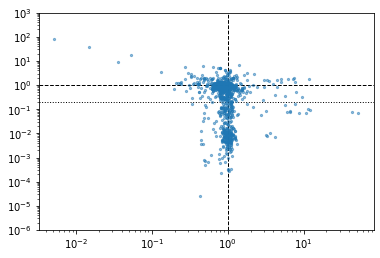

In [69]:
plt.scatter(mean_normalized_cvrg_B1A, cvrg_ratio_B1A, s=5, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-6, 1e3)
plt.axhline(1, lw=1, linestyle='--', color='k', zorder=0)
plt.axhline(1/5, lw=1, linestyle=':', color='k', zorder=0)
plt.axvline(1, lw=1, linestyle='--', color='k', zorder=0)

In [78]:
(np.abs(np.log2(mean_normalized_cvrg_B1A)) > 1).mean()

0.03790199081163859

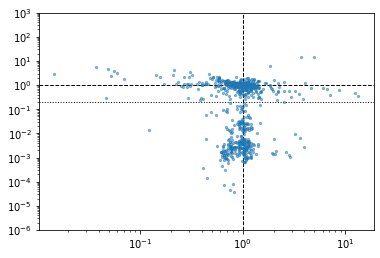

In [70]:
plt.scatter(mean_normalized_cvrg_B1B, cvrg_ratio_B1B, s=5, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-6, 1e3)
plt.axhline(1, lw=1, linestyle='--', color='k', zorder=0)
plt.axhline(1/5, lw=1, linestyle=':', color='k', zorder=0)
plt.axvline(1, lw=1, linestyle='--', color='k', zorder=0)

In [79]:
(np.abs(np.log2(mean_normalized_cvrg_B1B)) > 1).mean()

0.034725093013642